In [2]:
import os
import keras
import numpy as np
import tensorflow as tf
from keras.applications import vgg19

base_image_path = "./images/img.JPG"
style_reference_image_path = "./images/style.png"
result_prefix = "./gen/img"

# Dimensions of the generated picture.
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

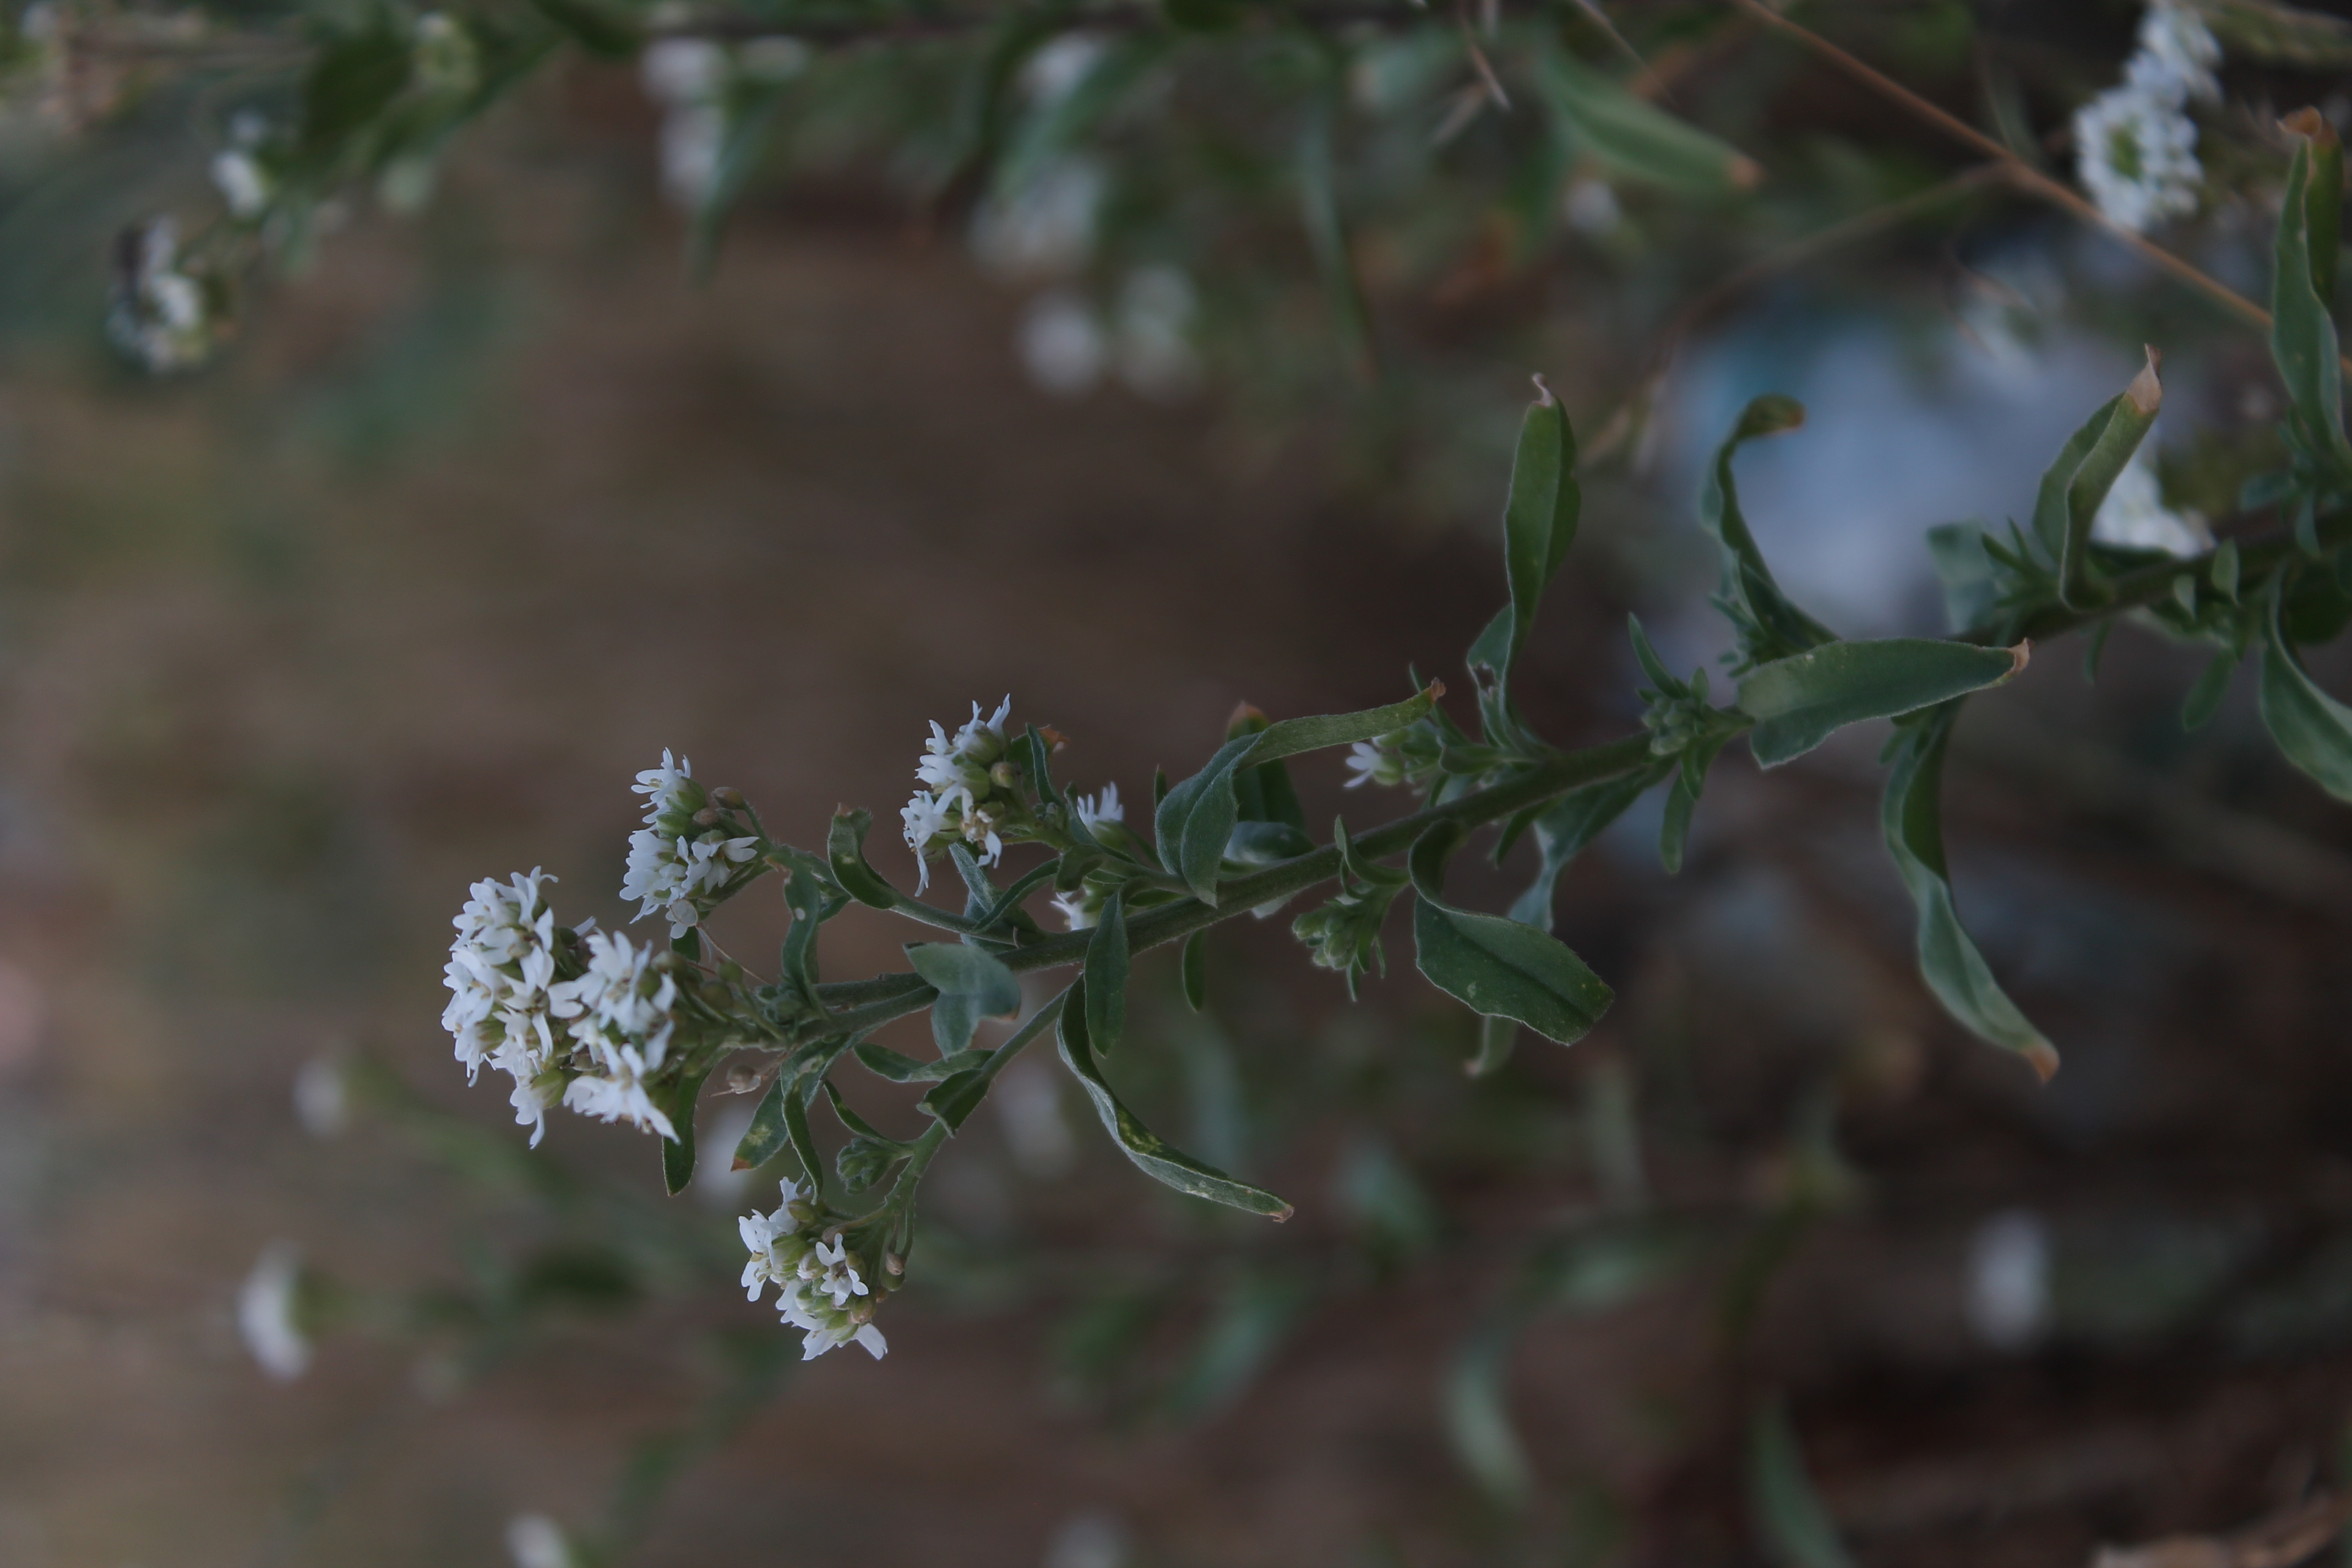

In [3]:
from IPython.display import Image, display

display(Image(base_image_path))

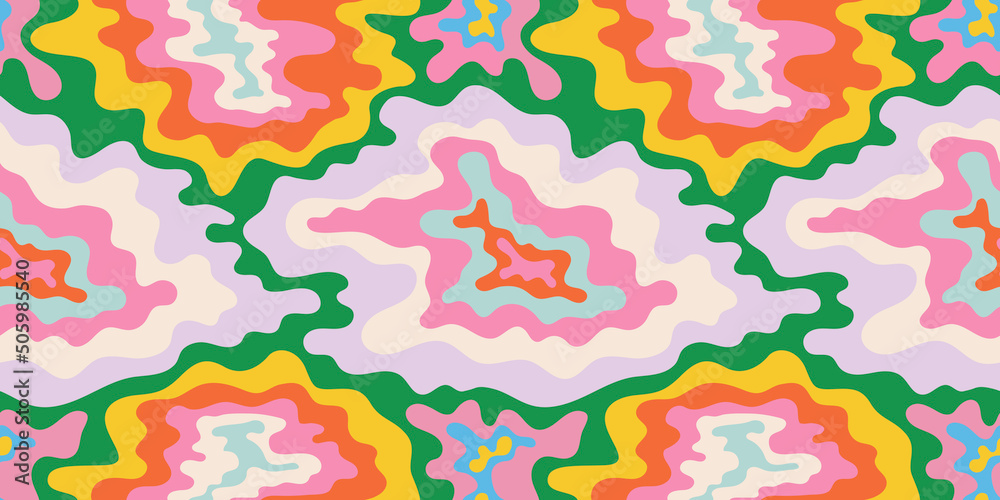

In [4]:
display(Image(style_reference_image_path))

In [5]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # 'BGR'->'RGB'
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols

    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


def content_loss(base, combination):
    # sd
    return tf.reduce_sum(tf.square(combination - base))


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [6]:
model = vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [15]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layer_name = "block5_conv2"


total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [8]:
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [9]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

In [17]:
# gradient
# optimizer = optimizers.legacy.SGD(
#     optimizers.schedules.ExponentialDecay(
#         initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
#     )
# )

optimizer = optimizers.legacy.Adam(learning_rate=50, beta_1=0.99, epsilon=1e-1)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 20
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 1 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "adam_at_iteration_%d_v2.png" % i
        keras.utils.save_img(fname, img)

Iteration 1: loss=330570.47
Iteration 2: loss=316076.84
Iteration 3: loss=293724.72
Iteration 4: loss=266944.66
Iteration 5: loss=238874.45
Iteration 6: loss=211574.70
Iteration 7: loss=185791.58
Iteration 8: loss=162753.78
Iteration 9: loss=143384.88
Iteration 10: loss=127933.83
Iteration 11: loss=116238.10
Iteration 12: loss=107715.56
Iteration 13: loss=101485.94
Iteration 14: loss=96829.24
Iteration 15: loss=93197.01
Iteration 16: loss=90205.03
Iteration 17: loss=87575.35
Iteration 18: loss=85188.45
Iteration 19: loss=83015.45
Iteration 20: loss=81111.29
